<a href="https://colab.research.google.com/github/lagerasimov/Analysis-of-the-effectiveness-of-advertising-campaigns-using-AB-testing/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%BE%D0%B2_AB_%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В ходе данного проекта произведён анализ результатов A/B-теста.

Датасет с данными для исследования [взят с сайта "Kaggle"](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data). В таблице содержатся следующие столбцы:

*   Index — индекс строки
*   user_id — уникальный идентификатор пользователя
*   test_group — группа в тесте: ad — пользователь видел рекламу, psa — пользователь видел лишь публичное объявление (социальную рекламу)
*   converted — факт покупки: True — товар куплен, False — покупки не было
*   total_ads — общее количество просмотренных реклам/публичных объявлений
*   most_ads_day — день с максимальным количеством показов пользователю
*   most_ads_hour — час дня с максимальным количеством показов

##Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.proportion import proportions_ztest

##Загружаем и обрабатываем данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'https://drive.google.com/uc?export=download&id=1VQPWBm-AYu4Fe7r3QqF0qvc36wBm8al3'
df = pd.read_csv(path)

Посмотрим на структуру таблицы:

In [ ]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


Заметим, что индексы в таблице дублируются. Удалим лишнее:

In [ ]:
df.drop(columns = ['Unnamed: 0'], inplace = True)
df

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


Посмотрим, есть ли у нас колонки с пропущенными значениями (nan). Получим, что таких значений нет:

In [ ]:
df.isna().sum()

,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


Посмотрим на типы значений в столбцах:

In [ ]:
df.dtypes

,0
user id,int64
test group,object
converted,bool
total ads,int64
most ads day,object
most ads hour,int64


In [ ]:
df['user id'].is_unique

True

Как мы видим, все значения в столбце 'user id' уникальные, поэтому он нам не понадобится. Удалим его:

In [ ]:
df.drop(columns=['user id'], inplace=True)
df

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14
...,...,...,...,...,...
588096,ad,False,1,Tuesday,23
588097,ad,False,1,Tuesday,23
588098,ad,False,3,Tuesday,23
588099,ad,False,1,Tuesday,23


Итак, будем работать с 5 колонками и 588100 столбцами.

##Анализ зависимости конверсии от группы

Посмотрим на конверсию в каждой из групп и сравним их:

In [ ]:
#Группируем данные
conversion_data = df.groupby('test group')['converted'].mean().reset_index()
print('Конверсии по группам:\n', conversion_data)

#Ищем разность между конверсиями
max_row = conversion_data.loc[conversion_data['converted'].idxmax()]
min_row = conversion_data.loc[conversion_data['converted'].idxmin()]
print(f'Группа {max_row["test group"]} имеет конверсию выше на {(max_row["converted"] - min_row["converted"]):.2%}')

Конверсии по группам:
   test group  converted
0         ad   0.025547
1        psa   0.017854
Группа ad имеет конверсию выше на 0.77%


Как мы видим, конверсии весьма различаются.

Визуализируем данные на графике:

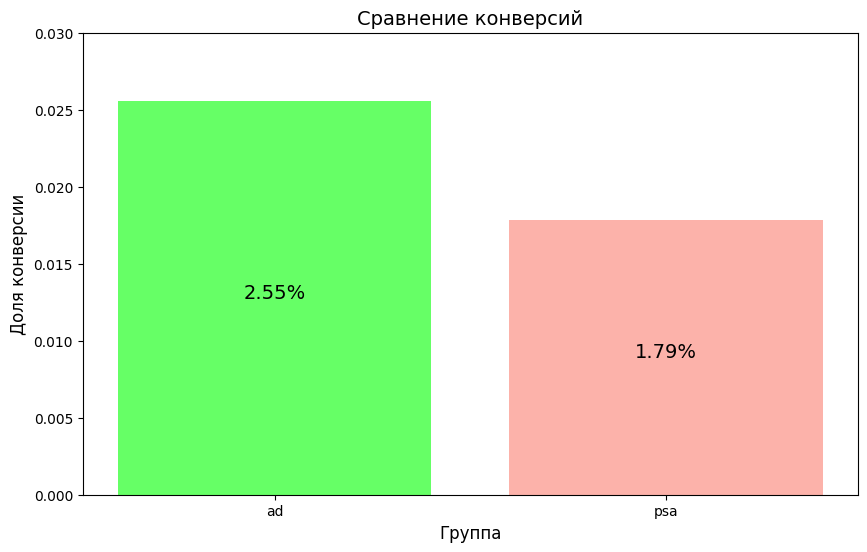

In [ ]:
#Создание графика
plt.figure(figsize=(10, 6))
plt.bar(conversion_data['test group'], conversion_data['converted'], color=['lime', 'salmon'], alpha = 0.6)
plt.title('Сравнение конверсий', fontsize=14)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Доля конверсии', fontsize=12)
plt.ylim(0, 0.03)

#Добавление подписей
for i, height in enumerate(conversion_data['converted']):
  plt.text(i, height/2, f"{height*100:.3}%", fontsize = 14, ha = 'center')

Узнаем, сколько людей было в каждой группе

In [ ]:
print("Число людей по группам:")
print(df['test group'].value_counts())

print("\nДоля людей по группам:")
print(df['test group'].value_counts(normalize=True))

Число людей по группам:
test group
ad     564577
psa     23524
Name: count, dtype: int64

Доля людей по группам:
test group
ad     0.96
psa    0.04
Name: proportion, dtype: float64




*   Число людей, которым было показано рекламное объявление, значительно выше (их 96%), чем тех, кому просто показали публичное объявление (4%). Это может серьёзно повлиять на достоверность сравнения.
*   Конверсия в преобладающей группе - 2.55%, тогда как во второй группе - 1.79%. Такое различие может говорить о положительном влиянии рекламного объявления на конверсию.

**Тестирование гипотезы**

Проведём T-тест для сравнения коэффициентов конверсии. В нашем случае:

1. **Нулевая гипотеза:** Существенной разницы между конверсиями в первой и второй группах нет.

2. **Альтернативная гипотеза:** Между конверсиями в двух группах наблюдается существенно значимая разница (реклама повышает уровень конверсии).

Для корректной работы преобразуем тип колонки 'converted' на целочисленный:

In [ ]:
df['converted'] = df['converted'].astype(int)
df.dtypes

,0
test group,object
converted,int64
total ads,int64
most ads day,object
most ads hour,int64


In [ ]:
#Выделяем группы
psa_group = df[df['test group'] == 'psa']
ad_group = df[df['test group'] == 'ad']

#Проводим тест
t_stat, p_val = ttest_ind(ad_group['converted'], psa_group['converted'])
print(f"Test Group Analysis - T-statistic: {t_stat}, P-value: {p_val}")

Test Group Analysis - T-statistic: 7.37040597428566, P-value: 1.7033052627831264e-13


* Показатель T-распределения получился весьма большой, а значит
между средними значениями в двух группах наблюдается большая разница.

* P-value получилось очень маленьким, поэтому можем смело отвергать нулевую гипотезу (показатель явно ниже общепринятого 0.05).

**Вывод:** Результаты теста показывают статистически значимое различие: группа ad демонстрирует более высокую конверсию по сравнению с группой psa. Это значит, что показ рекламного объявления более значим для нас.

##Анализ зависимости конверсии от дня недели

In [ ]:
#Группируем данные по дням недели
day_data = df.groupby('most ads day')['converted'].mean().reset_index()
day_data

,most ads day,converted
0,Friday,0.022212
1,Monday,0.032812
2,Saturday,0.021051
3,Sunday,0.024476
4,Thursday,0.021571
5,Tuesday,0.029840
6,Wednesday,0.024942


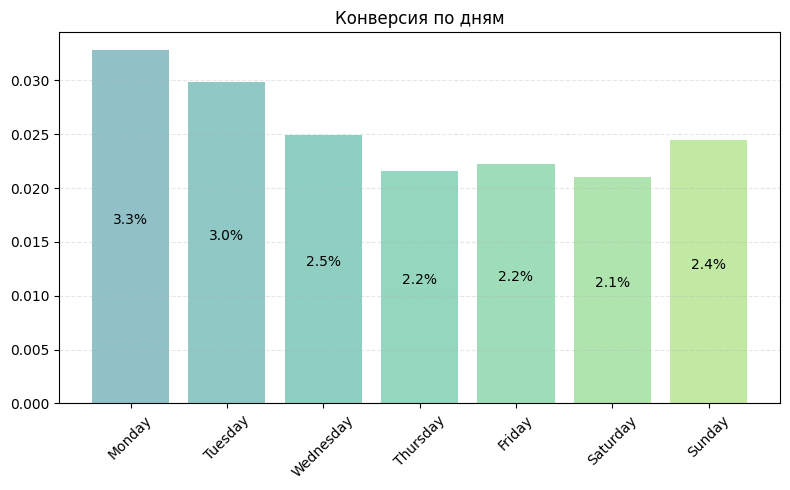

In [ ]:
# Задаём правильный порядок дней недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Группируем данные
day_data = (df.groupby('most ads day')['converted']
            .mean()
            .reindex(days_order)
            .reset_index())

# Строим график
plt.figure(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0.45, 1, 10), alpha = 0.5 )
bars = plt.bar(day_data['most ads day'], day_data['converted'], color=colors)
plt.title('Конверсия по дням')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height/2, f'{height:.1%}',
             ha='center', va='bottom')

plt.show()

Как видно по графику, средняя конверсия достигает своего пика в начале недели - понедельник и вторник.
Можем предположить, что конверсия зависит от дней недели. Проведём соответствующую гипотезу и протестируем её. Для проверки будем использовать F-тест (ANOVA).

**Нулевая гипотеза:** День недели не оказывает существенного влияния на конверсию.

**Альтернативная гипотеза:** День недели оказывает серьёзное влияния на конверсию.

In [ ]:
# Проводим F-тест
anova_result = f_oneway(*[df[df['most ads day'] == day]['converted'] for day in days_order])

# Выводим результаты
print("Результаты теста:")
print("F-статистика:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

Результаты теста:
F-статистика: 68.38818386898062
p-value: 1.8032007655359558e-85


**Вывод:** P-value получилось очень низким. Можем смело отклонять нулевую гипотезу и утверждать, что конверсия действительно зависит от дня недели.

Мы рассматривали данные в общем случае. Теперь попробуем посмотреть на зависимость для каждой группы отдельно.

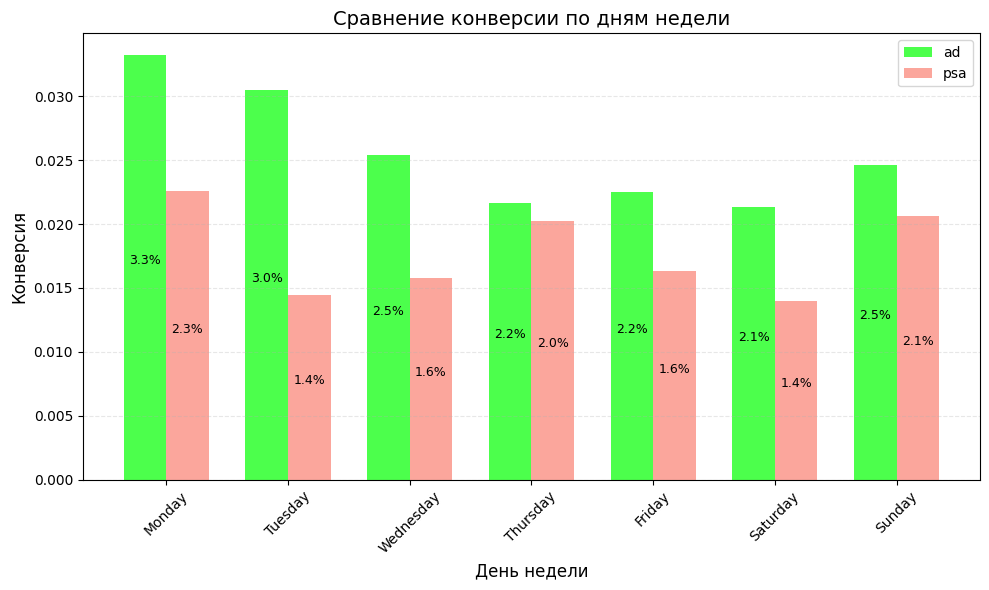

In [ ]:
# Группируем данные для каждой из групп
ad_data = (df[df['test group'] == 'ad']
           .groupby('most ads day')['converted']
           .mean()
           .reindex(days_order)
           .reset_index())

psa_data = (df[df['test group'] == 'psa']
            .groupby('most ads day')['converted']
            .mean()
            .reindex(days_order)
            .reset_index())

# Настраиваем график
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(days_order))

# Столбцы для групп
bars_ad = plt.bar(x - width/2, ad_data['converted'], width,
                 color='lime', alpha=0.7, label='ad')

bars_psa = plt.bar(x + width/2, psa_data['converted'], width,
                   color='salmon', alpha=0.7, label='psa')

# Оформление
plt.title('Сравнение конверсии по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.xticks(x, days_order, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Подписываем значения
for bars in [bars_ad, bars_psa]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height/2, f'{height:.1%}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Для преобладающей группы конверсия распределена примерно так же, как в общем случае. То есть здесь зависимость будет примерно такой же, как и в общем случае.

Понедельник - день с самой высокой конверсией, как для первой, так и для второй группы.

Однако для 'psa' распределение иное и между днями нет таких резких различий. Поэтому стоит провести F-тест - узнать, есть ли в этом случае реальная зависимость между днём недели и конверсией.


**Нулевая гипотеза:** День недели не оказывает существенного влияния на конверсию.

**Альтернативная гипотеза:** День недели оказывает серьёзное влияние на конверсию.

In [ ]:
psa_df = df[df['test group'] == 'psa']

# Создаем список данных по дням недели
psa_day_groups = [psa_df[psa_df['most ads day'] == day]['converted'] for day in days_order]

f_stat, p_value = f_oneway(*psa_day_groups)

print("Результаты:")
print(f"F-статистика: {f_stat:}")
print(f"p-value: {p_value:}")

Результаты:
F-статистика: 2.122674085135708
p-value: 0.047465561910824364


**Вывод:** P-value куда выше, чем в общем случае. Однако, так как оно меньше, чем 0.05 (общепринятая граница), можем отклонить нулевую гипотезу. То есть и сейчас мы получили, что день недели, в которые показывается реклама/публичное объявление, существенно влияет на результат.

Тем не менее, зависимость эта куда менее ярко выражена по сравнению с группой 'ad': кроме увеличенного p-value, значение F-статистики так же заметно изменилось - уменьшилось более чем в 30 раз.

##Анализ зависимости конверсии от времени суток

In [ ]:
# Группируем данные по часам
hour_data = (df.groupby('most ads hour')['converted']
             .mean()
             .reset_index()
             .sort_values('most ads hour'))

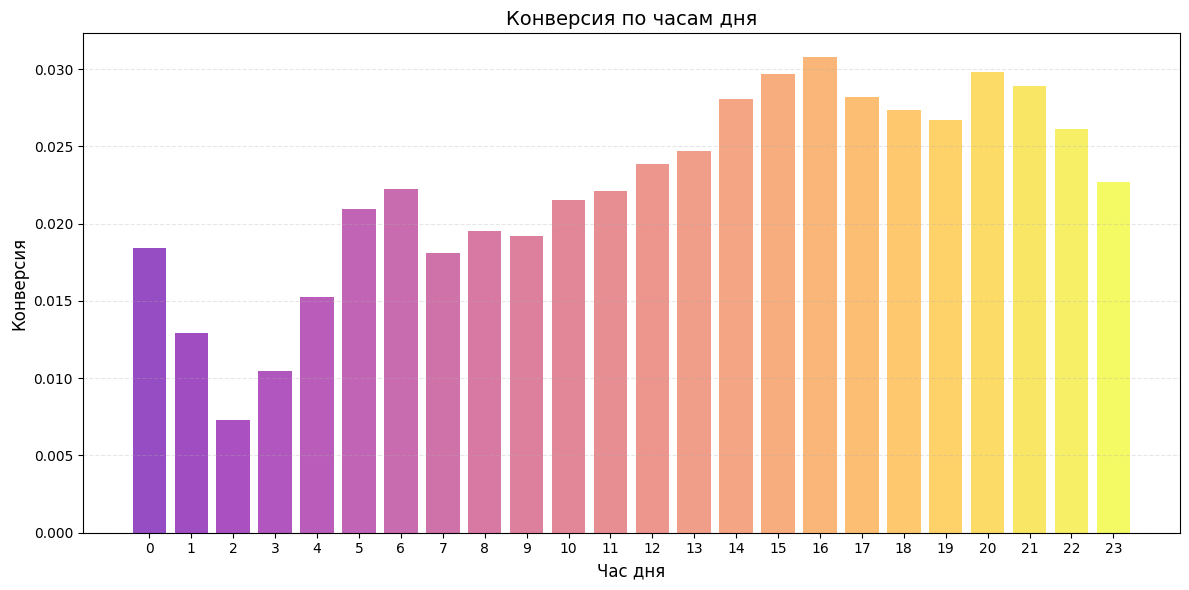

In [ ]:
# Строим график
plt.figure(figsize=(12, 6))
colors = plt.cm.plasma(np.linspace(0.2, 1, 24), alpha=0.7)
bars = plt.bar(hour_data['most ads hour'], hour_data['converted'], color=colors)
plt.title('Конверсия по часам дня', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)
plt.xticks(range(24))  # все часы
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Конверсия максимальна во второй половине дня и минимальна ночью. Это, в целом, неудивительно.

Проведём F-test:

**Нулевая гипотеза:** Конверсия не зависит от времени суток.

**Альтернативная гипотеза:** Время суток существенно влияет на конверсию.

In [ ]:
# Проводим F-тест
anova_hour_result = f_oneway(*[df[df['most ads hour'] == hour]['converted'] for hour in range(24)])

# Выводим результаты
print("Результаты теста:")
print(f"F-статистика: {anova_hour_result.statistic}")
print(f"p-value: {anova_hour_result.pvalue}")

Результаты теста:
F-статистика: 18.742037312974496
p-value: 7.482025334833055e-77


Как и в прошлый раз, p-value оказалось очень низким.

**Вывод:** Можем смело отклонять нулевую гипотезу. В нашем случае время суток действительно влияет на конверсию. В целом, это было очевидно. Статистический метод подтвердил наши ожидания

Теперь рассмотрим группы по отдельности:

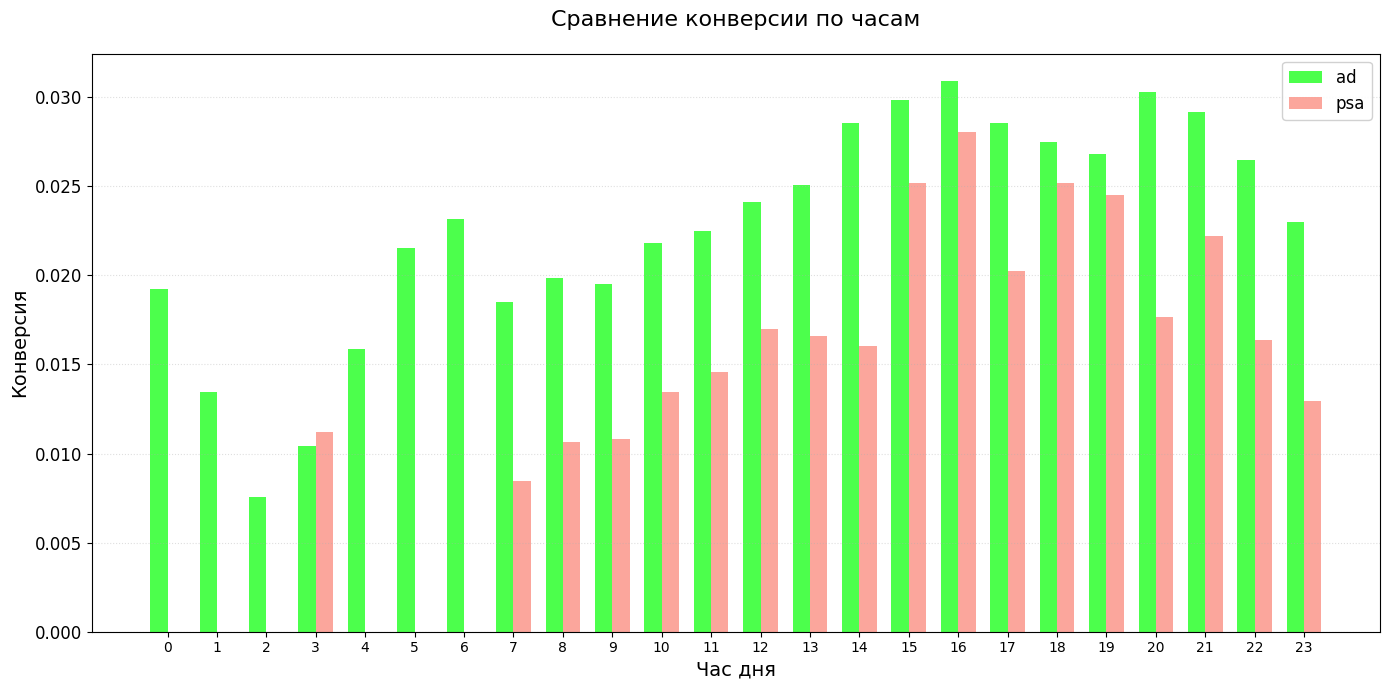

In [ ]:
# Данные для каждой группы
ad_hour_data = (df[df['test group'] == 'ad']
                .groupby('most ads hour')['converted']
                .mean()
                .reset_index()
                .sort_values('most ads hour'))

psa_hour_data = (df[df['test group'] == 'psa']
                 .groupby('most ads hour')['converted']
                 .mean()
                 .reset_index()
                 .sort_values('most ads hour'))

# Строим график
plt.figure(figsize=(14, 7))
width = 0.35
x = np.arange(24)

# Столбцы для групп
plt.bar(x - width/2,
        ad_hour_data['converted'],
        width,
        color='lime',
        alpha=0.7,
        label='ad')

plt.bar(x + width/2,
        psa_hour_data['converted'],
        width,
        color='salmon',
        alpha=0.7,
        label='psa')

# Оформление
plt.title('Сравнение конверсии по часам', fontsize=16, pad=20)
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Конверсия', fontsize=14)
plt.xticks(x, range(24))
plt.yticks(fontsize=12)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(axis='y', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

Для первой группы ('ad') зависимость схожа с общей. Во второй - зависимость от времени суток выражена ещё более ярко (в первом половине дня значение корреляции для некоторых часов и вовсе нулевое).

##Анализ зависимости решения о покупке от числа объявлений

Посмотрим на зависимость для группы 'ad'

<ipython-input-88-82b61f31158f>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


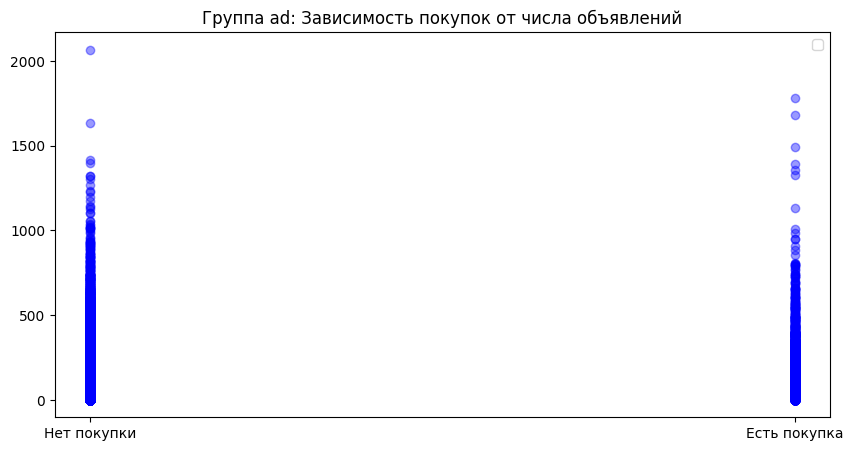

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(ad_group['converted'], ad_group['total ads'], alpha=0.4, color='blue')
plt.title('Группа ad: Зависимость покупок от числа объявлений')
plt.xticks([0, 1], ['Нет покупки', 'Есть покупка'])
plt.legend()
plt.show()

И для группы 'psa'

<ipython-input-89-458b8115c873>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


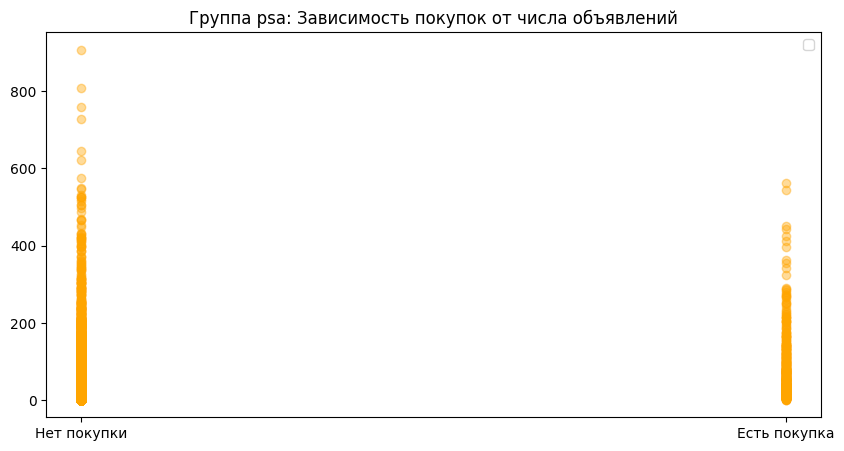

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(psa_group['converted'], psa_group['total ads'], alpha=0.4, color='orange')
plt.title('Группа psa: Зависимость покупок от числа объявлений')
plt.xticks([0, 1], ['Нет покупки', 'Есть покупка'])
plt.legend()
plt.show()

Сформулируем статистические гипотезы:

**Нулевая гипотеза:** Конверсия пользователей, увидевших более N объявлений, равна общей конверсии группы

**Альтернативная гипотеза:** Конверсия пользователей, увидевших более N объявлений, отличается от общей конверсии группы

N возьмём равным 400 для первой группы, 150 - для второй

Проведём анализ с помощью z-теста для сравнения пропорций


In [ ]:
def analyze_group(group, group_name, threshold):
    high_ads = group[group['total ads'] > threshold]

    conv_rate = high_ads['converted'].mean()
    total_conv = group['converted'].mean()

    count = high_ads['converted'].sum()
    nobs = len(high_ads)
    z_stat, p_value = proportions_ztest(count, nobs, total_conv)

    print(f'''{group_name} (порог {threshold}):
    Конверсия при более {threshold} объявлений - {conv_rate}, общая - {total_conv}
    p-value: {p_value} {'(значимо)' if p_value < 0.05 else '(незначимо)'}
    Размер выборки: {len(high_ads)}/{len(group)} ({len(high_ads)/len(group)})
    ''')

# Анализ с индивидуальными порогами
analyze_group(ad_group, 'Группа ad', 400)
analyze_group(psa_group, 'Группа psa', 150)

Группа ad (порог 400):
    Конверсия при более 400 объявлений - 0.15985130111524162, общая - 0.025546559636683747
    p-value: 2.737092679770445e-33 (значимо)
    Размер выборки: 1076/564577 (0.0019058516375977058)
    
Группа psa (порог 150):
    Конверсия при более 150 объявлений - 0.1320754716981132, общая - 0.01785410644448223
    p-value: 1.7309987869474394e-13 (значимо)
    Размер выборки: 477/23524 (0.02027716374766196)
    


**Вывод:** Можем смело отклонять нулевую гипотезу. Чем больше объявлений увидел пользователь, тем скорее он согласится на покупку (ведь конверсия в выводе выше увеличилась)

##Заключение

Анализ данных выявил существенные различия в эффективности между группами: таргетированная рекламная кампания (ad) показала более высокую конверсию по сравнению с публичными объявлениями (psa). Также были обнаружены значимые временные паттерны пользовательской активности, указывающие на пиковую вовлеченность в понедельник и во второй половине дня. Увеличение количества показов объявлений (как в ad, так и в psa) коррелирует с повышением конверсии.

Результаты анализа предоставляют ценную информацию для оптимизации. Сосредоточение на рекламных объявлениях, таргетирование по времени и увеличение количества показов - это ключевые факторы для повышения конверсии.